In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import argrelmax, argrelmin

In [2]:
# path to hdf5 file
path_hdf5 = '/home/philipp/Data/modis/modis_smooth.h5'

hdf5_modis = h5py.File(path_hdf5, 'r')

In [3]:
wht = hdf5_modis['whittaker']

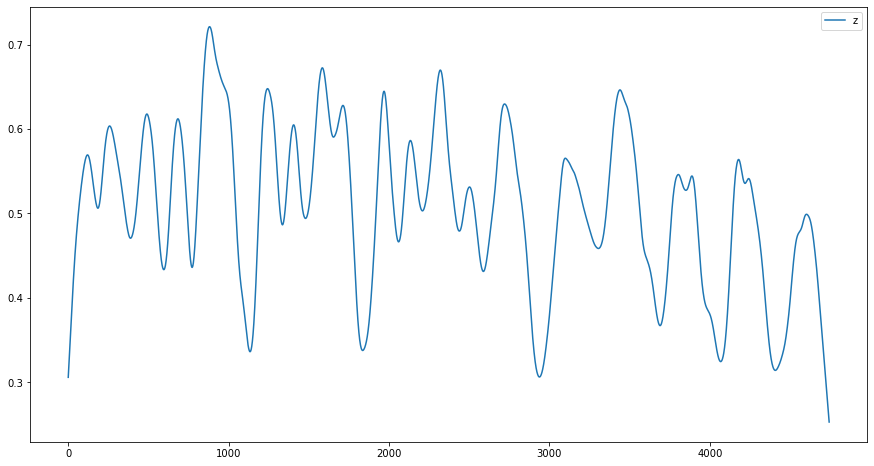

In [4]:
# plot time series of pixel
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(wht[650,905,:], label='z')
ax.legend()

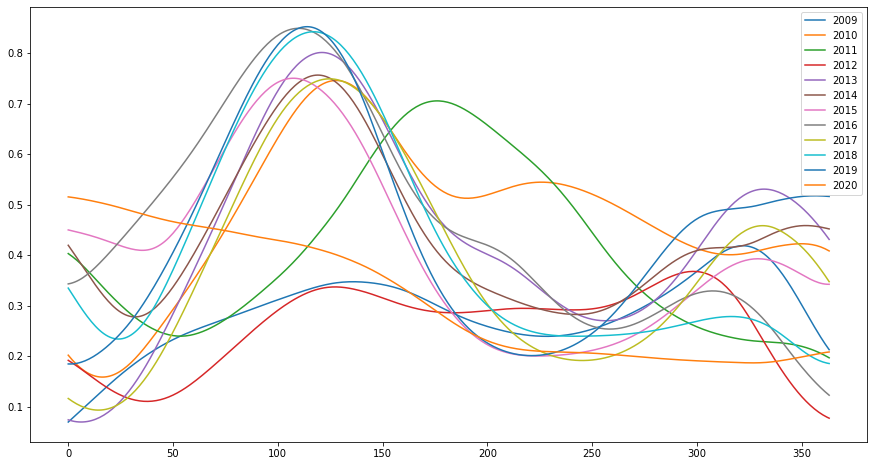

In [5]:
x = 0
y = 365
#z = wht[0,157,:]
z = wht[30,1256,:]
#z = wht[930,520,:]
#z = wht[910,510,:]

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(z[x+1:x+y], label='2009')
ax.plot(z[x+y*1+1:x+y*2], label='2010')
ax.plot(z[x+y*2+1:x+y*3], label='2011')
ax.plot(z[x+y*3+1:x+y*4], label='2012')
ax.plot(z[x+y*4+1:x+y*5], label='2013')
ax.plot(z[x+y*5+1:x+y*6], label='2014')
ax.plot(z[x+y*6+1:x+y*7], label='2015')
ax.plot(z[x+y*7+1:x+y*8], label='2016')
ax.plot(z[x+y*8+1:x+y*9], label='2017')
ax.plot(z[x+y*9+1:x+y*10], label='2018')
ax.plot(z[x+y*10+1:x+y*11], label='2019')
ax.plot(z[x+y*11+1:x+y*12], label='2020')
ax.legend()

In [6]:
def clip_years(arr, start_year, end_year, offset=0):
    
    x = 0
    y = 365

    pixel = {}

    for i in range(0,end_year-start_year):
        pixel[start_year+i] = np.array(arr[x+y*i+1+offset:x+y*(i+1)+offset])
        
    return pixel

In [28]:
def get_pheno_sos(pixel, year):
    
    if pixel[year].all() == 0:
        return -1, -1, 0
        
    else:
        # find index of 20% -> SOS
        
        # get all maxima
        idxs_max = argrelmax(pixel[year])[0]
        # get number of maxima
        nr_max = idxs_max.size
        
        # no maxima found
        if nr_max == 0:
            idx_max = np.argmax(pixel[year])
            if idx_max < 10:
                return -1, -1, 0
            else:
                nr_max = 1
        # one maximum found
        elif nr_max == 1:
            # get the maximum of the season
            idx_max = idxs_max[0]
        # more maxima found
        elif nr_max > 1:
            for idx_m in idxs_max:
                if pixel[year][idx_m] >= np.max(pixel[year])*0.5:
                    idx_max = idx_m
                    break
                else:
                    idx_max = np.argmax(pixel[year])
                    
        # get maximum value
        maximum = pixel[year][idx_max]
        
        # get minimum in beginning of the season
        idx_min = np.argmin(pixel[year][:idx_max])
        minimum = pixel[year][idx_min]

        # calculate SOS
        pix_20 = (maximum-minimum)*0.2 + minimum

        # find index (days since the beginning of the year) of SOS
        idx_20 = (np.abs(pixel[year][idx_min:idx_max] - pix_20)).argmin()
            
    return idx_20, idx_max, nr_max

In [8]:
def get_pheno_eos(pixel, year, idx_max, offset=0):
    
    if (pixel[year].all() == 0) | (idx_max == -1):
        return -1
    
    else:
        idx_max -= offset
        
        # find index of 20% -> EOS
        idx_min = np.argmin(pixel[year][idx_max:])
        
        # get maximum value
        minimum = pixel[year][idx_min]
        maximum = pixel[year][idx_max]

        # calculate SOS
        pix_20 = (maximum-minimum)*0.2 + minimum

        # find index (days since the beginning of the year) of SOS
        idx_20 = (np.abs(pixel[year][idx_max:idx_min] - pix_20)).argmin()

    return idx_20 + offset

In [9]:
start_year = 2009
end_year = 2021

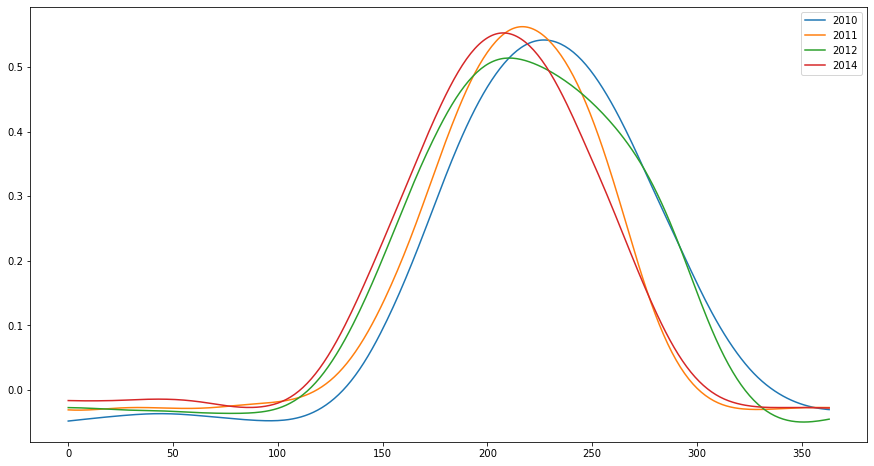

In [23]:
x = 0
y = 365

a = 35
b = 368
# plot time series of pixel
#z = wht[0,157,:]
z = wht[a,b,:]
#z = wht[930,520,:]
#z = wht[910,510,:]

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(z[x+y*1+1:x+y*2], label='2010')
ax.plot(z[x+y*2+1:x+y*3], label='2011')
ax.plot(z[x+y*3+1:x+y*4], label='2012')
ax.plot(z[x+y*5+1:x+y*6], label='2014')
ax.legend()

In [27]:
year = 2011

pixel = clip_years(z, start_year, end_year, offset=0)

idx_20, idx_max, nr_max = get_pheno_sos(pixel, year)
print(idx_20, idx_max, nr_max)

3 [ 33 217 357]
137 217 3


In [12]:
year = 2012

idxs_max = np.unique(hdf5_modis['MOS'][a,b,:])
print(idxs_max)

try:
    if idxs_max[0] == -1:
        offset = idxs_max[1]
    else:
        offset = idxs_max[0]
except:
    offset = 0
print(offset)

idx_max = np.unique(hdf5_modis['MOS'][a,b,int(year-start_year)])[0]
print(idx_max)

pixel = clip_years(z, start_year, end_year, offset=offset)

idx_20 = get_pheno_eos(pixel, year, idx_max, offset)
print(idx_20)

[ -1 107 110 114 117 119 121 125 127 128 136 176]
107
127
322


In [13]:
# path to hdf5 file
path_hdf5 = '/home/philipp/Data/modis/modis_smooth_eos.h5'

# create / open file
hdf5_modis_eos = h5py.File(path_hdf5, 'a')

In [ ]:
typ = 'SOS'

# y-coordinates
for y in range(hdf5_modis['whittaker'].shape[0]):
    print(y)
    # x-coordinates
    for x in range(hdf5_modis['whittaker'].shape[1]):
        #print(x)

        pixel = clip_years(hdf5_modis['whittaker'][y,x,:], start_year, end_year, offset=0)
            
        # years
        for year in range(start_year, end_year):
            #print(year)
            
            # SOS
            hdf5_modis_eos['SOS'][y,x,year-start_year], \
            hdf5_modis_eos['MOS'][y,x,year-start_year], \
            hdf5_modis_eos['peaks'][y,x,year-start_year] = get_pheno_sos(pixel, year)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


In [48]:
typ = 'EOS'

# y-coordinates
for y in range(hdf5_modis['whittaker'].shape[0]):
    print(y)
    # x-coordinates
    for x in range(hdf5_modis['whittaker'].shape[1]):
        print(x)
        
        idxs_max = np.unique(hdf5_modis['MOS'][y,x,:])
        
        try:
            if idxs_max[0] == -1:
                offset = idxs_max[1]
            else:
                offset = idxs_max[0]
        except:
            offset = 0
            
        pixel = clip_years(hdf5_modis['whittaker'][y,x,:], start_year, end_year, offset=offset)
            
        # years
        for year in range(start_year, end_year):
            print(year)
            
            idx_max = hdf5_modis['MOS'][y,x,year-start_year]
            # SOS
            hdf5_modis_eos['EOS'][y,x,year-start_year] = get_pheno_eos(pixel, year, idx_max, offset=offset)

0
0
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
1
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
3
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
4
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
5
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
6
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
7
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
8
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
9
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
10
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
11
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
12
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
13
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
14
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
15
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


2019
2020
155
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
156
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
157
2009
2010


ValueError: attempt to get argmin of an empty sequence

In [94]:
hdf5_modis_eos.close()

In [92]:
# path to hdf5 file
path_hdf5 = '/home/philipp/Data/modis/modis_smooth_eos.h5'

# create / open file
hdf5_modis_eos = h5py.File(path_hdf5, 'a')

if not os.path.isfile(path_hdf5):
    print('file not found -> creating file')
    
# create dataset
hdf5_modis_eos.create_dataset('peaks',\
                       (hdf5_modis['whittaker'].shape[0], hdf5_modis['whittaker'].shape[1],\
                       (end_year-start_year)), dtype=np.int16)
                       
# create dataset
hdf5_modis_eos.create_dataset('SOS',\
                       (hdf5_modis['whittaker'].shape[0], hdf5_modis['whittaker'].shape[1],\
                       (end_year-start_year)), dtype=np.int16)

# create dataset
hdf5_modis_eos.create_dataset('MOS',\
                       (hdf5_modis['whittaker'].shape[0], hdf5_modis['whittaker'].shape[1],\
                       (end_year-start_year)), dtype=np.int16)

# create dataset
#hdf5_modis_eos.create_dataset('EOS',\
#                       (hdf5_modis['whittaker'].shape[0], hdf5_modis['whittaker'].shape[1],\
#                       (end_year-start_year)), dtype=np.int16)

# create dataset
hdf5_modis_eos.create_dataset('LOS',\
                       (hdf5_modis['whittaker'].shape[0], hdf5_modis['whittaker'].shape[1],\
                       (end_year-start_year)), dtype=np.int16)

<HDF5 dataset "LOS": shape (1299, 1864, 12), type "<i2">

In [93]:
hdf5_modis_eos.keys()

<KeysViewHDF5 ['EOS', 'LOS', 'MOS', 'SOS', 'peaks']>